In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [27]:
from astropy import units as u
from astropy.table import join, Table

import matplotlib.pyplot as plt
import numpy
import seaborn

from catalogues import Catalogue

import swasputils

In [3]:
superwasp_sources = swasputils.FoldedLightcurves().df
superwasp_sources['SuperWASP Coords'] = superwasp_sources['SWASP ID'].replace(r'^1SWASP', '', regex=True)
superwasp_periods = Table.from_pandas(superwasp_sources[['Period', 'SuperWASP Coords']])

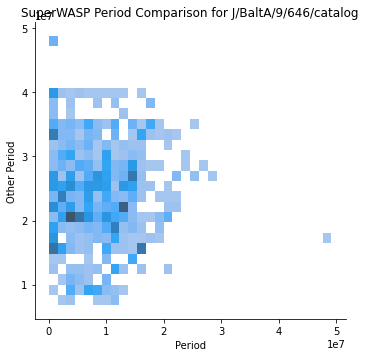

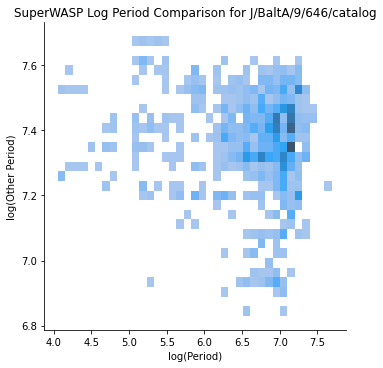

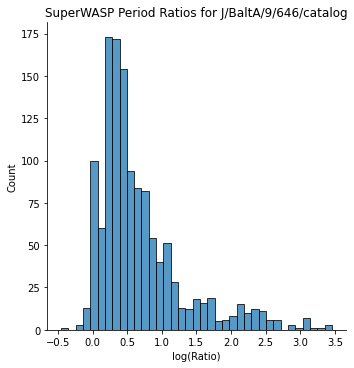

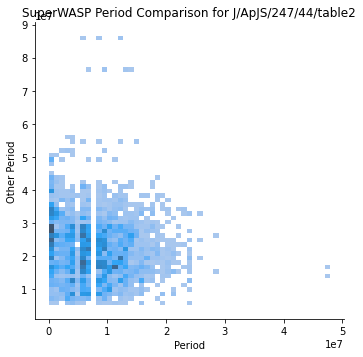

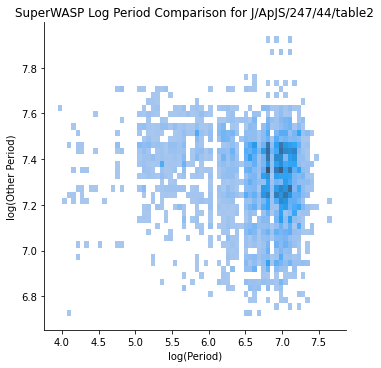

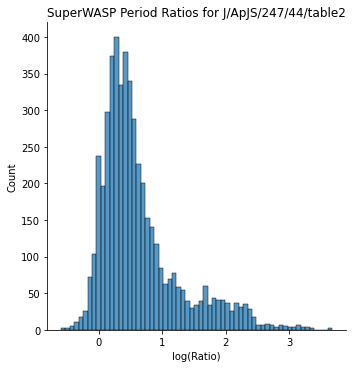

In [42]:
for catalogue in Catalogue.all():
    matched_table = catalogue.matched_table
    matched_table['Other Period'] = matched_table[catalogue.per_col].to(u.second)
    matched_periods = join(matched_table[['Other Period', 'SuperWASP Coords']], superwasp_periods).to_pandas()
    matched_periods['log(Period)'] = numpy.log10(matched_periods['Period'])
    matched_periods['log(Other Period)'] = numpy.log10(matched_periods['Other Period'])
    matched_periods['Ratio'] = matched_periods['Other Period'] / matched_periods['Period']
    matched_periods['log(Ratio)'] = numpy.log10(matched_periods['Ratio'])

    seaborn.displot(data=matched_periods, x='Period', y='Other Period').set(title=f'SuperWASP Period Comparison for {catalogue}')
    plt.show()
    
    seaborn.displot(data=matched_periods, x='log(Period)', y='log(Other Period)').set(title=f'SuperWASP Log Period Comparison for {catalogue}')
    plt.show()
    
    seaborn.displot(data=matched_periods, x="log(Ratio)").set(title=f'SuperWASP Period Ratios for {catalogue}')
    plt.show()